In [1]:
%matplotlib inline

In [2]:
# !pip uninstall transformers
!pip install transformers==3.5

In [3]:
import logging
import time
from platform import python_version
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [4]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.6.9
pandas==1.1.5
numpy==1.19.5
torch==1.7.0+cu101
sklearn==0.22.2.post1
transformers==3.5.0
matplotlib==3.2.2


In [5]:
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# df = pd.read_csv('drive/MyDrive/train.csv')
df = pd.read_csv('drive/MyDrive/reviews.csv')
df.shape

(358957, 6)

In [8]:
random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [9]:
df = df.sample(frac=1)
df = df.reset_index(drop=True)

In [10]:
df.head()

,user_id,prod_id,rating,label,date,review
0,58479,251,4.0,1,2010-05-01,"Went on a Friday night at about 5:30 PM, it wa..."
1,39714,202,4.0,1,2014-10-26,"Nice ambiance, very nice staff and good food. ..."
2,101723,523,5.0,1,2013-11-17,we went to the city for a long weekend and rea...
3,33349,100,5.0,1,2010-07-12,Foods tasted: Walnut french toast Blueberry pa...
4,23432,305,5.0,1,2014-12-16,LOVE the new space. It wasn't too overly packe...


In [11]:
# df.comment_text[0]
df.review[0]

'Went on a Friday night at about 5:30 PM, it was still early and plenty of seats were available. \xa0Its a very cool nondescript vibe in here, I liked it though. \xa0For drinks I had the Penicillin and the Pomegranate Sour, the former was tart and sweet. It was the better of the two. \xa0Husband had the pickle juice martini and that was really good. You really get like a nice mild pickle flavor as the drink finishes in your mouth. For food we just had a couple of appetizers: the hamachi with wasabi cream and soybeans and the pork buns. \xa0Both were delicious especially the pork buns. \xa0I doused them with a liberal amount of sircacha and it did not make it incredibly spicy. It just added to the richness of the flavors. \xa0Very enjoyable cool place and I am looking forward to coming back here.'

In [12]:
# target_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# df.iloc[[103]][target_columns]

target_columns = ["label"]
df.iloc[[103]][target_columns]

,label
103,1


In [13]:
df_train = df[:10000].reset_index(drop=True)
df_val = df[10000:11000].reset_index(drop=True)
df_test = df[11000:13000].reset_index(drop=True)

In [14]:
df_train.shape

(10000, 6)

In [15]:
df_val.shape

(1000, 6)

In [16]:
df_test.shape

(2000, 6)

In [17]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'

In [18]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [19]:
max_seq = 30

In [20]:
def tokenize_text(df, max_seq):
    return [
        # tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.comment_text.values
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.review.values
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [21]:
train_indices = tokenize_and_pad_text(df_train, max_seq)
val_indices = tokenize_and_pad_text(df_val, max_seq)
test_indices = tokenize_and_pad_text(df_test, max_seq)

Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors


In [22]:
with torch.no_grad():
    x_train = bert_model(train_indices)[0]  # Models outputs are tuples
    x_val = bert_model(val_indices)[0]
    x_test = bert_model(test_indices)[0]

In [23]:
y_train = targets_to_tensor(df_train, target_columns)
y_val = targets_to_tensor(df_val, target_columns)
y_test = targets_to_tensor(df_test, target_columns)

In [24]:
x_train[0]

tensor([[ 6.5355e-04, -5.9795e-02,  3.6013e-01,  ..., -9.4116e-01,
          3.7106e-01, -2.4679e-01],
        [-1.3350e-01, -3.6086e-01,  5.3668e-01,  ..., -9.7294e-01,
          6.2427e-01, -7.6214e-02],
        [-3.8279e-01, -5.6181e-01,  1.7381e-01,  ..., -7.2725e-01,
          4.0075e-01,  7.8115e-02],
        ...,
        [ 2.4551e-01,  3.2521e-02,  3.9446e-01,  ..., -1.0495e+00,
          2.9889e-01, -4.0031e-01],
        [-9.9070e-02, -4.7349e-02,  5.2690e-01,  ..., -9.8018e-01,
          3.9076e-01, -1.5049e-01],
        [ 1.4652e-01, -1.9551e-01,  2.9518e-01,  ..., -1.1921e+00,
          3.8039e-01, -1.9757e-01]])

In [25]:
x_train[0].shape

torch.Size([30, 768])

In [26]:
y_train[0]

tensor([1.])

In [27]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [28]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [29]:
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [30]:
n_epochs = 10
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [31]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [32]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

Epoch 1 Train loss: 0.53. Validation loss: 0.54. Elapsed time: 17.01s.
Epoch 2 Train loss: 0.51. Validation loss: 0.54. Elapsed time: 16.73s.
Epoch 3 Train loss: 0.50. Validation loss: 0.55. Elapsed time: 16.90s.
Epoch 4 Train loss: 0.49. Validation loss: 0.54. Elapsed time: 16.83s.
Epoch 5 Train loss: 0.49. Validation loss: 0.54. Elapsed time: 16.70s.
Epoch 6 Train loss: 0.48. Validation loss: 0.57. Elapsed time: 16.84s.
Epoch 7 Train loss: 0.48. Validation loss: 0.55. Elapsed time: 16.95s.
Epoch 8 Train loss: 0.47. Validation loss: 0.55. Elapsed time: 16.87s.
Epoch 9 Train loss: 0.46. Validation loss: 0.55. Elapsed time: 16.76s.
Epoch 10 Train loss: 0.46. Validation loss: 0.57. Elapsed time: 16.82s.


Text(0.5, 1.0, 'Losses')

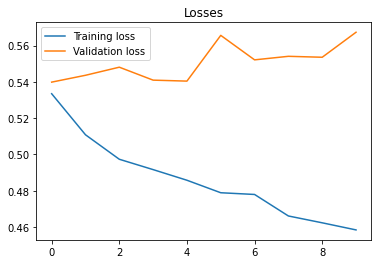

In [33]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [34]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [35]:
y_preds_np

array([[0.88402194],
       [0.97084844],
       [0.70481408],
       ...,
       [0.90974367],
       [0.69465822],
       [0.91142833]])

In [36]:
y_test_np = df_test[target_columns].values

In [37]:
y_test_np[1000:]

array([[ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],

In [38]:
auc_scores = roc_auc_score(y_test_np, y_preds_np, average=None)
df_accuracy = pd.DataFrame({"label": target_columns, "auc": auc_scores})
df_accuracy.sort_values('auc')[::-1]

,label,auc
0,label,0.556087


In [39]:
positive_labels = df_train[target_columns].sum().sum()
positive_labels

7920

In [40]:
all_labels = df_train[target_columns].count().sum()
all_labels

10000

In [41]:
positive_labels/all_labels

0.792

In [42]:
df_test_targets = df_test[target_columns]
df_pred_targets = pd.DataFrame(y_preds_np.round(), columns=target_columns, dtype=int)
df_sanity = df_test_targets.join(df_pred_targets, how='inner', rsuffix='_pred')

In [43]:
df_sanity

,label,label_pred
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1995,1,1
1996,1,1
1997,1,1
1998,1,1


In [44]:
df_test_targets.sum()

label    1564
dtype: int64

In [45]:
df_pred_targets.sum()

label    1987
dtype: int64

In [46]:
df_sanity[df_sanity.label > 0][['label', 'label_pred']]

,label,label_pred
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1995,1,1
1996,1,1
1997,1,1
1998,1,1
